In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Import the dataset from keras
We can import the dataset conveniently from keras with the "load_data()" function.

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Print some of the labels
We print out the first 8 pictures of our train dataset with the respective labels. To represent the labels in a readable way (per default the labels are numbers), we created an array with the coresponding words.

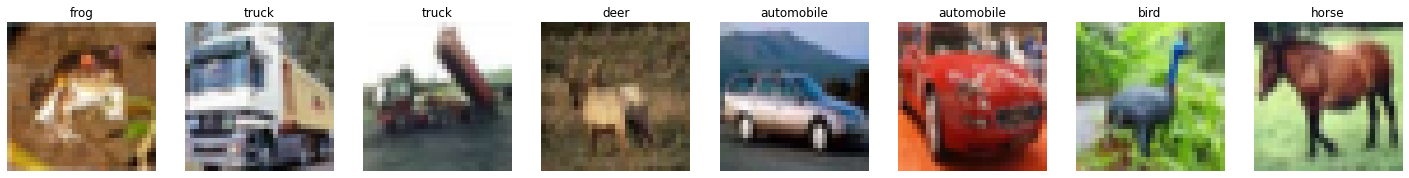

In [3]:
labels = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

fig, ax = plt.subplots(1,8, figsize=(25, 25))

for i in range(8):

  img = train_images[i]
  # transform the number we get into the written label
  label = labels[train_labels[i][0]]

  ax[i].imshow(img)
  ax[i].set_title(label)
  ax[i].axis('off')

# Input pipeline

In [4]:
### for train dataset
# create tf.Dataset for training dataset
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
# cast the images to float to allow for image normalization (they are uint8 before and we need the
# values to be in the continous range)
train_dataset_images = train_dataset_images.map(lambda x: tf.cast(x, dtype=tf.float32))
# normalize the images
train_dataset_images = train_dataset_images.map(lambda x: tf.image.per_image_standardization(x))
# create tf.Dataset for training labels
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels)
# one-hot encode the labels
train_dataset_labels = train_dataset_labels.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

# zip labels and images together again
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_labels))
# batching
train_dataset = train_dataset.batch(64)
# prefetch
train_dataset = train_dataset.prefetch(32)
# shuffle the images
train_dataset = train_dataset.shuffle(buffer_size=128)

### now the test dataset
# create tf.Dataset for test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
# cast to float
test_dataset_images = test_dataset_images.map(lambda x: tf.cast(x, dtype=tf.float32))
# normalize the images
test_dataset_images = test_dataset_images.map(lambda x: tf.image.per_image_standardization(x))
# create tf.Dataset for training labels
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)
# one-hot encode the labels
test_dataset_labels = test_dataset_labels.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

# zip labels and images together again
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_labels))
# batching
test_dataset = test_dataset.batch(64)
# prefetch
test_dataset = test_dataset.prefetch(32)
# shuffle the images
test_dataset = test_dataset.shuffle(buffer_size=128)

In [5]:
# we want to check which size the images have 
# because we need the shape for the first convolutional layer
# we get the shape = (128, 32, 32, 3)
# 128 is the batch size
# the size is 32x32
# and 3 channels for red, green, blue
for image,_ in train_dataset:
  print(image.shape)
  break

(64, 32, 32, 3)


In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(filters=channels, kernel_size=1,
                                        padding='same',
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                        activation=None)

    self.conv2 = tf.keras.layers.Conv2D(filters=channels, kernel_size=3,
                                        padding='same', 
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                        activation=None)
    self.conv3 = tf.keras.layers.Conv2D(filters=channels, kernel_size=1,
                                        padding='same', 
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                        activation=None)
    
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.batch_norm3 = tf.keras.layers.BatchNormalization()

    self.relu1 = tf.keras.layers.Activation(tf.keras.activations.relu)
    self.relu2 = tf.keras.layers.Activation(tf.keras.activations.relu)
    self.relu3 = tf.keras.layers.Activation(tf.keras.activations.relu)

  @tf.function
  def call(self, x, training=True):
    y = x

    x = self.conv1(x)
    x = self.batch_norm1(x, training)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.batch_norm2(x, training)
    x = self.relu2(x)
    x = self.conv3(x)
    x = self.batch_norm3(x, training)
    x = self.relu3(x)

    return x + y


In [7]:
class OutputBlock(tf.keras.layers.Layer):
  def __init__(self):
    super(OutputBlock, self).__init__()

    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.outputLayer = tf.keras.layers.Dense(units=10)
    self.activation = tf.keras.layers.Activation(tf.keras.activations.softmax)

  @tf.function
  def call(self, x, training=True):
    x = self.batch_norm(x, training)
    x = self.pooling(x)
    x = self.outputLayer(x)
    x = self.activation(x)

    return x

In [8]:
class ResNet(tf.keras.Model):
  def __init__(self, num_blocks=3, channels_in_block=256):
    super(ResNet, self).__init__()

    self.pre_block = [tf.keras.layers.Conv2D(filters=channels_in_block, kernel_size=3, 
                                             padding='same',
                                             input_shape=(32,32,3),
                                             kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                             activation=None
                                             )]
    self.pre_block.append(tf.keras.layers.BatchNormalization())
    self.pre_block.append(tf.keras.layers.Activation(tf.keras.activations.relu))
    self.pre_block.append(tf.keras.layers.MaxPool2D())

    self.blocks = []
    for _ in range(num_blocks):
        self.blocks.append(ResidualBlock(channels=channels_in_block))

    self.blocks.append(OutputBlock())
    
  @tf.function
  def call(self, x, training=True):
      for l in self.pre_block:
        x = l(x, training=training)

      for b in self.blocks:
        x = b(x, training)

      return x


In [9]:
class TransitionLayer(tf.keras.layers.Layer):
  def __init__(self, channels):
    super(TransitionLayer, self).__init__()

    self.conv = tf.keras.layers.Conv2D(filters=channels, kernel_size=1, 
                                        padding='same',
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                        activation=None)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
    self.pooling = tf.keras.layers.AveragePooling2D()

  @tf.function
  def call(self, x, training=True):
    x = self.conv(x)
    x = self.batch_norm(x, training)
    x = self.activation(x)
    x = self.pooling(x)

    return x

In [10]:
class ConvolutionLayer(tf.keras.layers.Layer):
  def __init__(self, channels):
    super(ConvolutionLayer, self).__init__()

    self.conv = tf.keras.layers.Conv2D(filters=channels, kernel_size=3, 
                                        padding='same',
                                        kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                        activation=None)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.Activation(tf.keras.activations.relu)
    self.concat = tf.keras.layers.Concatenate()

  @tf.function
  def call(self, x, training=True):
    y = x
    x = self.conv(x)
    x = self.batch_norm(x, training)
    x = self.activation(x)
    x = self.concat([x, y])

    return x

In [11]:
class DenseBlock(tf.keras.layers.Layer):
  def __init__(self, channels, num_conv_layers = 3):
    super(DenseBlock, self).__init__()

    self.conv_layers = [ConvolutionLayer(channels) for _ in range(num_conv_layers)]

  @tf.function
  def call(self, x, training=True):
    
    for l in self.conv_layers:
      x = l(x, training)

    return x

In [12]:
class DenseNet(tf.keras.Model):
  def __init__(self, num_layers = 3, growth_rate = 1, channels = 32):
    super(DenseNet, self).__init__()

    self.blocks = []
    
    for i in range(num_layers):
      self.blocks.append(DenseBlock(2, channels))

      if i < num_layers:
        self.blocks.append(TransitionLayer(channels * growth_rate))

    self.blocks.append(OutputBlock())

  @tf.function
  def call(self, x, training=True):
    
    for l in self.blocks:
      x = l(x, training)

    return x

In [13]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

In [14]:
def train_step(model, input, target, loss_function, optimizer, training=True):

    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input, training)
        loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss 

def test(model, test_data, loss_function, training=False):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input, training)
        sample_test_loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)

        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# Training plot

To actually see the performance of our Neural Network while training and not wait until it's finished with learning we created a plot which is updated every epoch. With that we are able see quite early if the model we just created performs rather good or bad. 


In [15]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
from IPython import display 

def plot(train_losses, test_losses, test_accuracies, figsize=(10,3)):
  #display.clear_output(wait=True)

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
  axes[0].plot(train_losses, label="training")
  axes[0].plot(test_losses, label="test")
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  #axes[0].set_ylim([0,5])
  axes[0].set_title("Loss", fontsize=20)
  axes[0].legend()
  axes[1].plot(test_accuracies)
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Accuracy")
  axes[1].set_title("Accuracy: " + str(round(np.max(test_accuracies), 3)), fontsize=20)
  plt.show()

# Training

In [16]:
def train(model):

  tf.keras.backend.clear_session()

  ### Hyperparameters
  num_epochs = 30
  learning_rate = 0.001
  running_average_factor = 0.95

  # Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
  # Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  # Initialize lists for later visualization.
  train_losses = []

  test_losses = []
  test_accuracies = []

  training_time = time.time()

  #testing once before we begin
  test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  #check how model performs on train data once before we begin
  train_loss, _ = test(model, train_dataset, cross_entropy_loss)
  train_losses.append(train_loss)

  
  # We train for num_epochs epochs.
  for epoch in range(num_epochs):
      epoch_time = time.time()

      #training (and checking in with training)
      running_average = 0
      for (input,target) in train_dataset:
          train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
          running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
      train_losses.append(running_average)

      #testing
      test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

      print(f"Epoch {str(epoch)}: training loss: {running_average}; test loss: {test_loss}; accuracy: {test_accuracy}; time {timing(epoch_time)} seconds")

  # Visualize final accuracy and loss for training and test data.
  plot(train_losses, test_losses, test_accuracies, figsize=(30,7))

  print(f"Training the model took {timing(training_time)} seconds")

  # how many parameters does our network have?
  model.summary()


Epoch 0: training loss: 1.7095091342926025; test loss: 2.02586030960083; accuracy: 0.3431528662420382; time 79.36 seconds
Epoch 1: training loss: 1.6258004903793335; test loss: 1.9736732244491577; accuracy: 0.4325238853503185; time 77.66 seconds
Epoch 2: training loss: 1.4891841411590576; test loss: 1.838991641998291; accuracy: 0.44745222929936307; time 77.88 seconds
Epoch 3: training loss: 1.3620619773864746; test loss: 1.5313431024551392; accuracy: 0.5379179936305732; time 78.5 seconds
Epoch 4: training loss: 1.3696314096450806; test loss: 1.6126981973648071; accuracy: 0.5158240445859873; time 77.46 seconds
Epoch 5: training loss: 1.3166922330856323; test loss: 1.5547988414764404; accuracy: 0.5089570063694268; time 77.6 seconds
Epoch 6: training loss: 1.2640889883041382; test loss: 1.596501111984253; accuracy: 0.5124402866242038; time 77.43 seconds
Epoch 7: training loss: 1.1971787214279175; test loss: 2.6962451934814453; accuracy: 0.36415207006369427; time 77.6 seconds
Epoch 8: trai

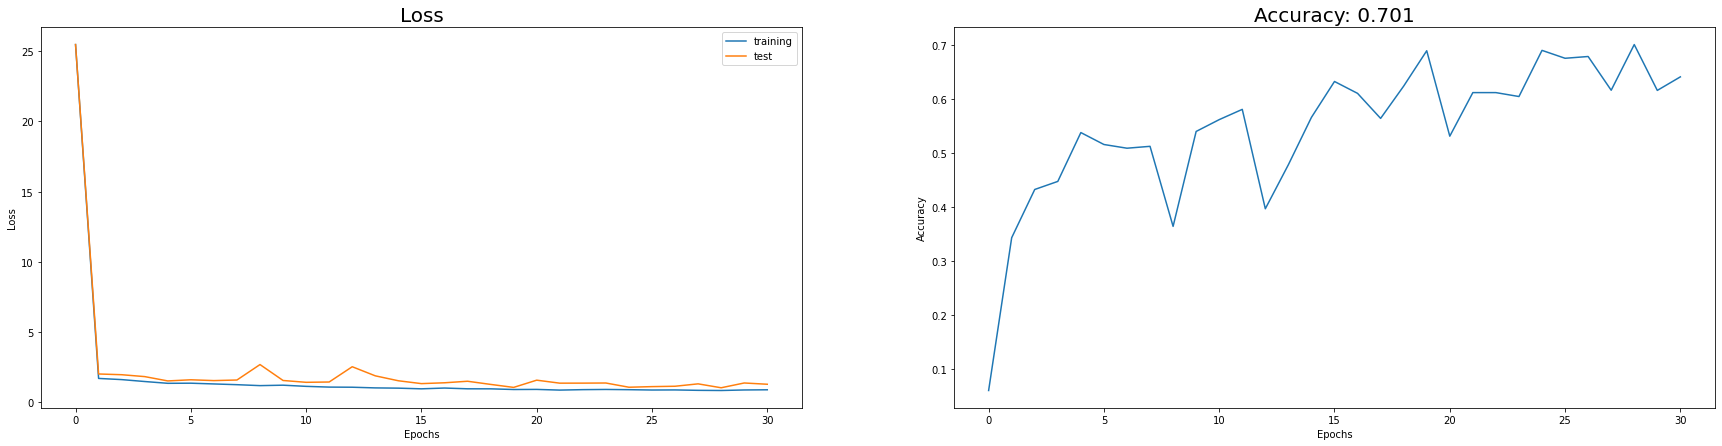

Training the model took 2367.3 seconds
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  7168      
_________________________________________________________________
batch_normalization (BatchNo multiple                  1024      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  724736    
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  724736    
_________________________________________________________________
residual_block_2 (Re

In [17]:
train(ResNet())

Epoch 0: training loss: 1.5401099920272827; test loss: 2.0480475425720215; accuracy: 0.42426353503184716; time 209.25 seconds
Epoch 1: training loss: 1.1860288381576538; test loss: 2.0827200412750244; accuracy: 0.4463574840764331; time 191.24 seconds
Epoch 2: training loss: 1.1370736360549927; test loss: 2.2533481121063232; accuracy: 0.44416799363057324; time 192.1 seconds
Epoch 3: training loss: 1.0505017042160034; test loss: 1.5301984548568726; accuracy: 0.5818073248407644; time 192.76 seconds
Epoch 4: training loss: 0.9916273355484009; test loss: 1.184671401977539; accuracy: 0.6841162420382165; time 193.31 seconds
Epoch 5: training loss: 0.9666820168495178; test loss: 1.5545296669006348; accuracy: 0.5799164012738853; time 190.83 seconds
Epoch 6: training loss: 0.902982771396637; test loss: 1.7396936416625977; accuracy: 0.5590167197452229; time 191.13 seconds
Epoch 7: training loss: 0.8983750343322754; test loss: 1.2253602743148804; accuracy: 0.6963574840764332; time 190.06 seconds
E

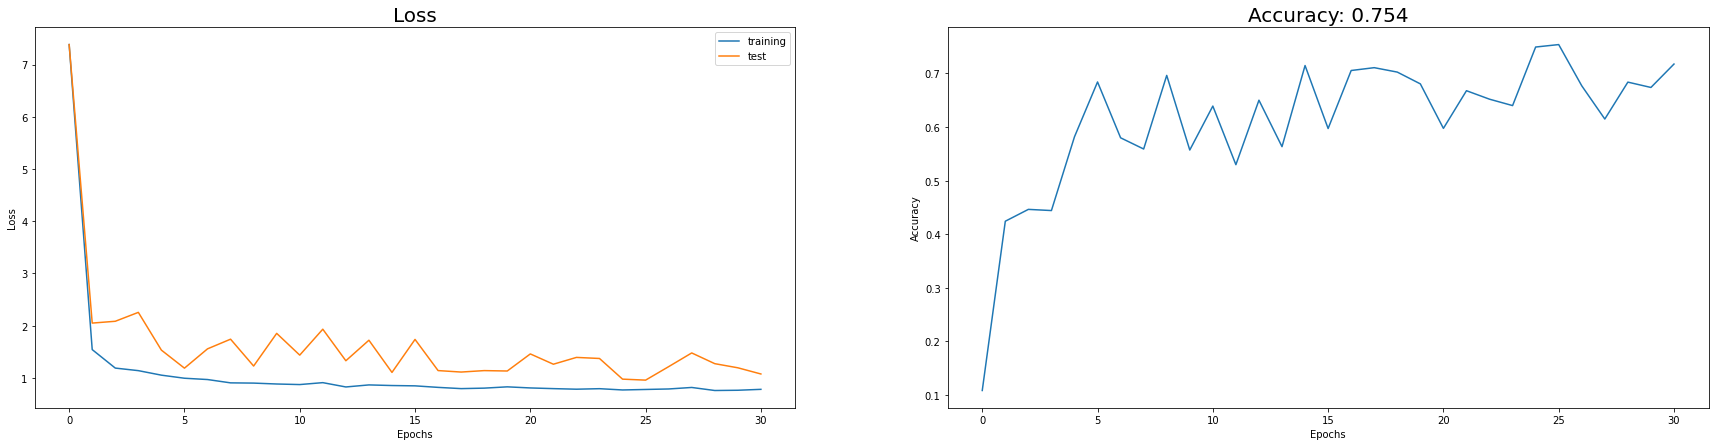

Training the model took 5882.32 seconds
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_block (DenseBlock)     multiple                  19904     
_________________________________________________________________
transition_layer (Transition multiple                  2304      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  36608     
_________________________________________________________________
transition_layer_1 (Transiti multiple                  3232      
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  36608     
_________________________________________________________________
transition_layer_2 (Transiti multiple                  3232      
_________________________________________________________________
output_block (Out

In [18]:
train(DenseNet())